# MNIST Image Classification using CNN

This project involves using deep neural networks to classify digits from the MNIST dataset. This task will be done by constructing a CNN using PyTorch.

## Data Loading

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Before loading the dataset, we'll define some transformations using torchvision.transforms.

When the data is loaded in, it is normalized with a mean of 0.1307 and a standard deviation of 0.3081,which are specific to the MNIST dataset.

Mean: 0.1307, represents the mean pixel intensity for the MNIST dataset

Standard deviation: 0.3081, represents the standard deviation of the pixel intensity

In [36]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(), # Convert the image to a 3 dimensional tensor
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize the image
])

# Load the training and test sets using transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define batch size and data loaders
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define classes
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Showing some of the training images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


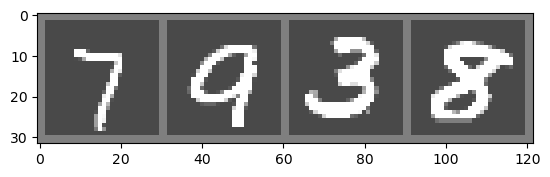

In [32]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show first 4 images
imshow(torchvision.utils.make_grid(images[:4]))

## Baseline Model (Fully Connceted)

Defining a fully connected network to get a baseline performance. We'll then compare this to the CNN once it is implemented.

In [42]:
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128) # First layer
        self.fc2 = nn.Linear(128, 64) # Second layer
        self.fc3 = nn.Linear(64, 10) # Output layer

    def forward(self, x):
        x = x.view(-1, 28*28) # Flattnes image to 1D vector
        x = F.relu(self.fc1(x)) # ReLU activation function for first layer
        x = F.relu(self.fc2(x)) # ReLU activation function for second layer
        x = self.fc3(x) # Output layer, no activation
        return x
    
# Instantiate model
fcnn = FullyConnectedNN().to(device)
print(fcnn)

FullyConnectedNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [43]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross entropy for classification
optimizer = torch.optim.Adam(fcnn.parameters(), lr=0.001) # Adam optimizer

In [44]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    fcnn.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass: compute predictions and loss
        output = fcnn(data)
        loss = criterion(output, target)

        # Backward pass: compute gradients and update weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/5], Loss: 0.2711
Epoch [2/5], Loss: 0.1098
Epoch [3/5], Loss: 0.0765
Epoch [4/5], Loss: 0.0602
Epoch [5/5], Loss: 0.0476


In [17]:
# Saving baseline model
PATH = './mnist_fcnn.pth'
torch.save(fcnn.state_dict(), PATH)

In [18]:
# Defining function to test model
def test_model(model, test_loader):
    model.eval() # Set model to evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad(): # Turn off gradients for validation
        for data, target in test_loader:
            # Move data to device
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item() # Sum test loss
            pred = output.argmax(dim=1, keepdim=True) # Get index of max logit
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

In [19]:
test_model(fcnn, test_loader)

Test Loss: 0.0013, Test Accuracy: 97.42%


**Baseline Performance:** 

Test Loss: 0.0013

Test Accuracy: 97.42%

## Convolutional Neural Network

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # First conv layer (input: 1 channel, output: 32 channels, kernel size: 3x3)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

        # Max pooling layer (2x2 window), stride set at 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second conv layer (input: 32 channels, output: 64 channels, kernel size: 3x3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Fully connected layer (64 channels * 7 * 7 image size)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)

        # Second fully connected layer (128 input features, 64 output features)
        self.fc2 = nn.Linear(128, 64)

        # Output layer (64 input features, 10 output features)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Conv layer 1, ReLU + pooling
        x = self.pool(F.relu(self.conv2(x))) # Conv layer 2, ReLU + pooling
        x = x.view(-1, 64 * 7 * 7) # Flatten image
        x = F.relu(self.fc1(x)) # Fully connected layer 1, ReLU
        x = F.relu(self.fc2(x)) # Fully connected layer 2, ReLU
        x = self.fc3(x) # output layer
        return x

# Instantiate model
cnn = CNN().to(device)
print(cnn)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [21]:
criterion = nn.CrossEntropyLoss() # Cross entropy for classification
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001) # Adam optimizer

In [22]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass: compute predictions and loss
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass: compute gradients and update weights
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/5], Loss: 0.1596
Epoch [2/5], Loss: 0.0489
Epoch [3/5], Loss: 0.0344
Epoch [4/5], Loss: 0.0247
Epoch [5/5], Loss: 0.0198


In [23]:
# Save model
PATH = './mnist_cnn.pth'
torch.save(cnn.state_dict(), PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


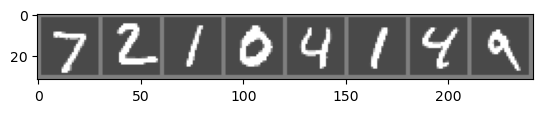

GroundTruth:      7     2     1     0     4     1     4     9


In [40]:
# Testing the model on 8 specific images pulled from the test set
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print 8 random images
imshow(torchvision.utils.make_grid(images[:8]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [41]:
# Predictions on 8 random images
outputs = cnn(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(8)))

Predicted:      7     2     1     0     4     1     4     9


We see that the model is accurately able to identify all 8 images that we pulled from the dataloader.

Let's see how the model performs on the entire dataset. We can use the previously defined test_model function we used for the baseline model.

In [39]:
# Test model, using the function defined earlier
test_model(cnn, test_loader)

Test Loss: 0.0006, Test Accuracy: 98.88%
